## Importing necessary libraries

In [1]:
import warnings
import requests
import numpy as np
import pandas as pd
import yfinance as yf
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from ta.trend import PSARIndicator
from datetime import datetime, timedelta

## Company Selection
- Purpose: Stores a dictionary of companies with their respective stock tickers.
- Usage: You can easily reference companies for fetching their stock data by using the dictionary.

In [2]:
companies = {'Reliance Industries Limited': 'RELIANCE.NS',
 'Tata Consultancy Services Limited': 'TCS.NS',
 'HDFC Bank Limited': 'HDFCBANK.NS',
 'Infosys Limited': 'INFY.NS',
 'ICICI Bank Limited': 'ICICIBANK.NS',
 'Kotak Mahindra Bank Limited': 'KOTAKBANK.NS',
 'Wipro Limited': 'WIPRO.NS',
 'Bharti Airtel Limited': 'BHARTIARTL.NS',
 'HCL Technologies Limited': 'HCLTECH.NS',
 'Axis Bank Limited': 'AXISBANK.NS',
 'Maruti Suzuki India Limited': 'MARUTI.NS',
 'NTPC Limited': 'NTPC.NS',
 'Adani Enterprises Limited': 'ADANIENT.NS',
 'Hero MotoCorp Limited': 'HEROMOTOCO.NS',
 'Tata Motors Limited': 'TATAMOTORS.NS',
 'Mahindra & Mahindra Limited': 'M&M.NS',
 'Bharat Petroleum Corporation Limited': 'BPCL.NS',
 'Oil and Natural Gas Corporation Limited': 'ONGC.NS',
 'Coal India Limited': 'COALINDIA.NS',
 'Power Grid Corporation of India Limited': 'POWERGRID.NS'}

## Data Loading Function
- Purpose: Loads stock data for a selected company from Yahoo Finance.
- Steps:
    - Displays a list of companies to the user.
    - Takes user input to select a company.
    - Downloads the data (last month, 2-minute intervals).
    - Returns the selected data in a pandas DataFrame.

In [3]:
def load_data():
    print("Select a company to fetch data:")
    for i, company in enumerate(companies.keys(), 1):
        print(f"{i}. {company}")

    choice = int(input("Enter the number of your choice: "))
    company_name = list(companies.keys())[choice - 1]
    ticker = companies[company_name]

    print(f"You selected: {company_name}")

    index_data = yf.download(ticker, period='1mo', interval="2m")

    index_data.reset_index(inplace=True)

    index_data = index_data[['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    return index_data

## Indicator Calculation Function
- Purpose: Calculates various technical indicators for stock data.
Indicators:
- SMA: Simple Moving Average
- EMA: Exponential Moving Average
- MACD: Moving Average Convergence Divergence
- RSI: Relative Strength Index
- Bollinger Bands: Upper and Lower bands based on standard deviation.
- OBV: On-Balance Volume
- Parabolic SAR: A trend-following indicator

In [4]:
def calculate_indicators(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_20'] = data['Close'].rolling(window=20).mean()

    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

    short_window = 6
    long_window = 13
    signal_window = 5

    data['EMA_6'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA_13'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA_6'] - data['EMA_13']
    data['MACD_Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    rsi_period = 9
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=rsi_period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=rsi_period).mean()
    
    rs = gain / loss.replace(0, np.nan)
    data['RSI'] = 100 - (100 / (1 + rs))

    data['Middle_Band'] = data['Close'].rolling(window=20).mean()
    data['Upper_Band'] = data['Middle_Band'] + 2 * data['Close'].rolling(window=20).std()
    data['Lower_Band'] = data['Middle_Band'] - 2 * data['Close'].rolling(window=20).std()

    data['OBV'] = (np.sign(data['Close'].diff()) * data['Volume']).fillna(0).cumsum()

    psar = PSARIndicator(
        high=data['High'], 
        low=data['Low'], 
        close=data['Close'], 
        step=0.02, 
        max_step=0.2
    )
    
    data['Parabolic_SAR'] = psar.psar()
    data['Parabolic_SAR_Up'] = psar.psar_up()
    data['Parabolic_SAR_Down'] = psar.psar_down()

    
    
    return data

## Signal Generation Function
- Purpose: Generates buy, sell, and reversal signals based on the calculated indicators.
- Conditions for signals:
    - Buy Signal: Combination of price being above various moving averages, MACD crossing above its signal, RSI in a neutral range, etc.
    - Sell Signal: Price below averages, RSI overbought, and other bearish conditions.
    - Bullish and Bearish Reversals: Based on Parabolic SAR movement.

In [5]:
def generate_signals(data):
    data['Buy_Signal'] = (
        (data['Close'] > data['SMA_10']) &
        (data['Close'] > data['EMA_10']) &
        (data['MACD'] > data['MACD_Signal']) &
        (data['RSI'] > 30) & (data['RSI'] < 70) &
        (data['Close'] > data['Lower_Band']) &
        (data['Close'] < data['Middle_Band']) &
        (data['OBV'] > data['OBV'].shift(1)) &
        (data['Parabolic_SAR'] < data['Close'])
    )

    data['Sell_Signal'] = (
        (data['Close'] < data['SMA_10']) |
        (data['Close'] < data['EMA_10']) |
        (data['MACD'] < data['MACD_Signal']) |
        (data['RSI'] > 70) |
        (data['Close'] > data['Upper_Band']) |
        (data['OBV'] < data['OBV'].shift(1)) &
        (data['Parabolic_SAR'] > data['Close'])
    )

    data['Bullish_Reversal'] = (
        (data['Parabolic_SAR'] < data['Close']) &
        (data['Parabolic_SAR'].shift(1) > data['Close'].shift(1))
    )

    data['Bearish_Reversal'] = (
        (data['Parabolic_SAR'] > data['Close']) &
        (data['Parabolic_SAR'].shift(1) < data['Close'].shift(1))
    )

    data['Buy_Signal'] = data['Buy_Signal'] | data['Bullish_Reversal']
    data['Sell_Signal'] = data['Sell_Signal'] | data['Bearish_Reversal']
    
    return data

## Latest Signal Function
- Purpose: Identifies the latest trading signal (buy/sell/hold) from the generated signals.
- Steps:
    - Checks the latest row in the data.
    - Returns "Buy" or "Sell" based on the latest signal.
    - If no signal, returns "Hold".

In [6]:
def get_latest_signal(data):
    latest_data = data.iloc[-1]
    signal = "Hold"
    if latest_data['Buy_Signal']:
        signal = "Buy"
    elif latest_data['Sell_Signal']:
        signal = "Sell"
    return signal

## Main Function
- Purpose: Main function that ties everything together.
- Steps:
    - Loads data from the user-selected company.
    - Calculates all technical indicators.
    - Generates buy/sell signals.
    - Plots graphs for various indicators:
        - Stock Price vs. Indicators (EMA, SMA, Bollinger Bands)
        - RSI Chart with overbought/oversold lines.
        - OBV Chart for volume analysis.
        - Parabolic SAR chart showing buy/sell points.
    - Prints the latest recommendation (buy/sell/hold).

In [7]:
def main():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    data = load_data()
    data = calculate_indicators(data)
    data = generate_signals(data)

    data['Datetime'] = pd.to_datetime(data['Datetime'])

    data['Date'] = data['Datetime'].dt.date
    data['Time'] = data['Datetime'].dt.time

    data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

    latest_signal = get_latest_signal(data)
    print(f"Based on the latest data, the recommended action for next min is: {latest_signal}")

    trace_close = go.Scatter(x=data['Datetime'], y=data['Close'], mode='lines', name='Close Price', line=dict(color='blue'))
    trace_ema10 = go.Scatter(x=data['Datetime'], y=data['EMA_10'], mode='lines', name='10-day EMA', line=dict(color='red'))
    trace_ema20 = go.Scatter(x=data['Datetime'], y=data['EMA_20'], mode='lines', name='20-day EMA', line=dict(color='green'))
    trace_upper_band = go.Scatter(x=data['Datetime'], y=data['Upper_Band'], mode='lines', name='Upper Bollinger Band', line=dict(color='purple'))
    trace_lower_band = go.Scatter(x=data['Datetime'], y=data['Lower_Band'], mode='lines', name='Lower Bollinger Band', line=dict(color='purple', dash='dash'))

    fig = go.Figure(data=[trace_close, trace_ema10, trace_ema20, trace_upper_band, trace_lower_band])
    fig.update_layout(
        title='Stock Data with Indicators and Signals',
        xaxis_title='Date and Time',
        yaxis_title='Value',
        hovermode='x',
        xaxis_rangeslider_visible=True,
        width=1200,
        height=800
    )
    fig.show()

    trace_rsi = go.Scatter(x=data['Datetime'], y=data['RSI'], mode='lines', name='RSI', line=dict(color='teal'))
    fig_rsi = go.Figure(data=[trace_rsi])
    fig_rsi.update_layout(
        title='RSI with Overbought and Oversold Levels',
        xaxis_title='Date and Time',
        yaxis_title='RSI Value',
        hovermode='x',
        xaxis_rangeslider_visible=True,
        width=1200,
        height=600
    )
    
    fig_rsi.add_shape(type="line",
                      x0=data['Datetime'].iloc[0], x1=data['Datetime'].iloc[-1], y0=70, y1=70,
                      line=dict(color="red", width=2, dash="dash"),
                      name='RSI Overbought (Sell)')

    fig_rsi.add_shape(type="line",
                      x0=data['Datetime'].iloc[0], x1=data['Datetime'].iloc[-1], y0=30, y1=30,
                      line=dict(color="green", width=2, dash="dash"),
                      name='RSI Oversold (Buy)')
    
    fig_rsi.show()

    trace_OBV_today = go.Scatter(
        x=data['Datetime'], 
        y=data['OBV'], 
        mode='lines', 
        name='OBV Today', 
        line=dict(color='red')
    )

    trace_OBV_yesterday = go.Scatter(
        x=data['Datetime'], 
        y=data['OBV'].shift(1), 
        mode='lines', 
        name='OBV Yesterday', 
        line=dict(color='blue')
    )

    fig_obv = go.Figure(data=[trace_OBV_today, trace_OBV_yesterday])

    fig_obv.update_layout(
        title='On-Balance Volume (OBV)',
        xaxis_title='Date and Time',
        yaxis_title='OBV Value',
        hovermode='x',
        xaxis_rangeslider_visible=True,
        width=1200,
        height=600
    )

    fig_obv.show()

    trace_close_psar = go.Scatter(
        x=data['Datetime'], 
        y=data['Close'], 
        mode='lines', 
        name='Close Price', 
        line=dict(color='blue')
    )

    trace_psar = go.Scatter(
        x=data['Datetime'], 
        y=data['Parabolic_SAR'], 
        mode='markers',
        name='Parabolic SAR', 
        marker=dict(color='red', symbol='circle', size=6)
    )

    fig_psar = go.Figure(data=[trace_close_psar, trace_psar])

    fig_psar.update_layout(
        title='Close Price and Parabolic SAR',
        xaxis_title='Date and Time',
        yaxis_title='Price',
        hovermode='x',
        xaxis_rangeslider_visible=True,
        width=1200,
        height=600
    )

    fig_psar.show()

Select a company to fetch data:
1. Reliance Industries Limited
2. Tata Consultancy Services Limited
3. HDFC Bank Limited
4. Infosys Limited
5. ICICI Bank Limited
6. Kotak Mahindra Bank Limited
7. Wipro Limited
8. Bharti Airtel Limited
9. HCL Technologies Limited
10. Axis Bank Limited
11. Maruti Suzuki India Limited
12. NTPC Limited
13. Adani Enterprises Limited
14. Hero MotoCorp Limited
15. Tata Motors Limited
16. Mahindra & Mahindra Limited
17. Bharat Petroleum Corporation Limited
18. Oil and Natural Gas Corporation Limited
19. Coal India Limited
20. Power Grid Corporation of India Limited


Enter the number of your choice:  5


You selected: ICICI Bank Limited


[*********************100%%**********************]  1 of 1 completed


Based on the latest data, the recommended action for next min is: Sell


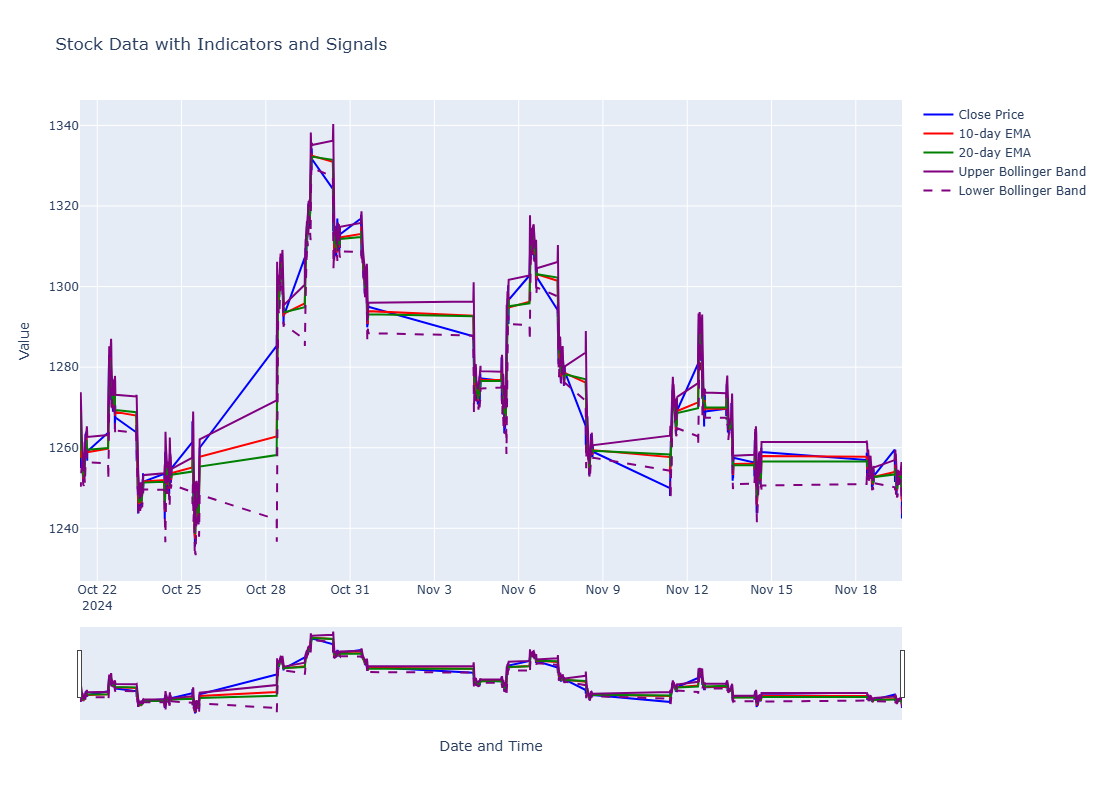

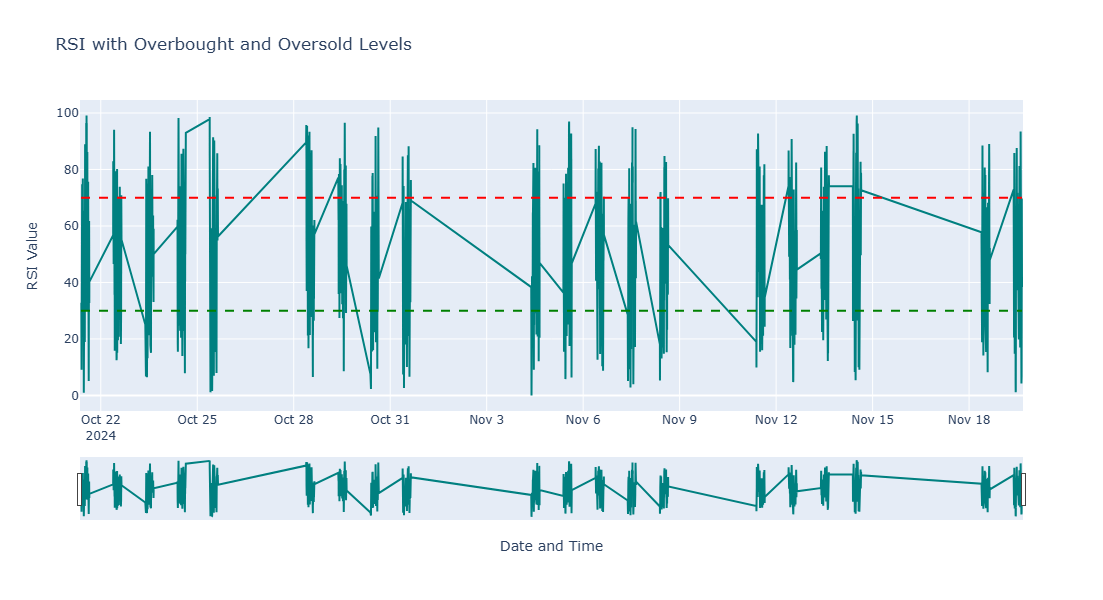

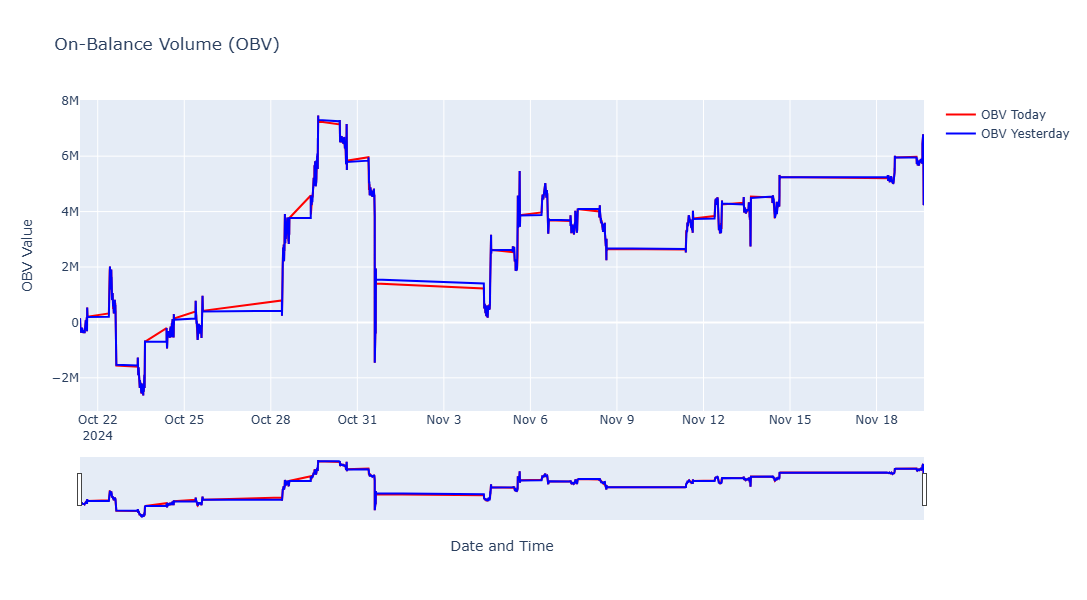

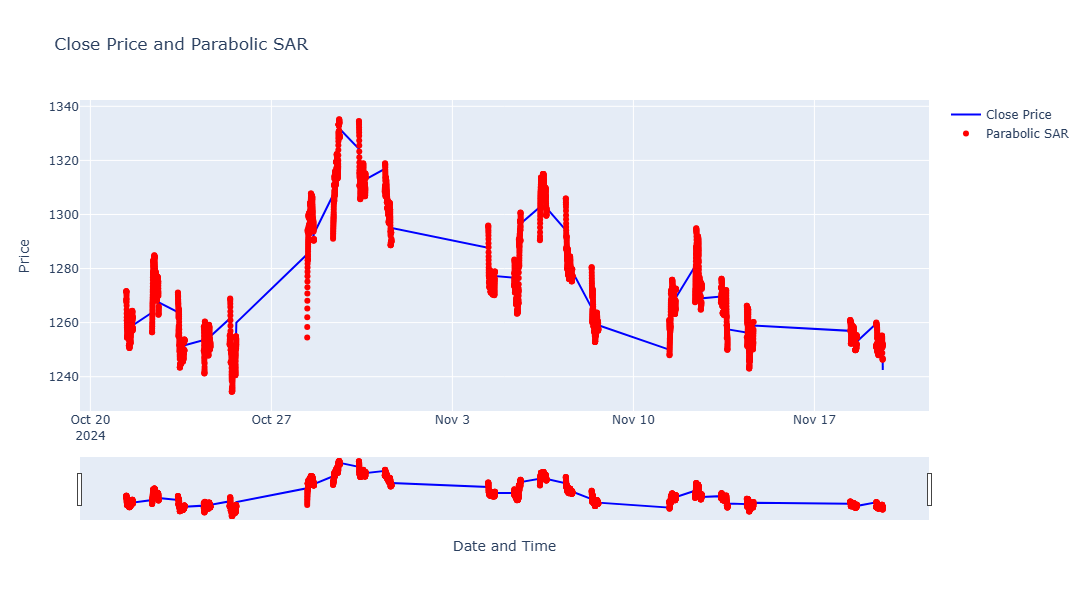

In [8]:
main()

In [9]:
load_data().tail()

Select a company to fetch data:
1. Reliance Industries Limited
2. Tata Consultancy Services Limited
3. HDFC Bank Limited
4. Infosys Limited
5. ICICI Bank Limited
6. Kotak Mahindra Bank Limited
7. Wipro Limited
8. Bharti Airtel Limited
9. HCL Technologies Limited
10. Axis Bank Limited
11. Maruti Suzuki India Limited
12. NTPC Limited
13. Adani Enterprises Limited
14. Hero MotoCorp Limited
15. Tata Motors Limited
16. Mahindra & Mahindra Limited
17. Bharat Petroleum Corporation Limited
18. Oil and Natural Gas Corporation Limited
19. Coal India Limited
20. Power Grid Corporation of India Limited


Enter the number of your choice:  5


[*********************100%%**********************]  1 of 1 completed

You selected: ICICI Bank Limited


Datetime         Open         High          Low  \
3750 2024-11-19 15:21:00+05:30  1251.050049  1251.500000  1248.150024   
3751 2024-11-19 15:23:00+05:30  1249.199951  1249.449951  1247.000000   
3752 2024-11-19 15:25:00+05:30  1246.949951  1246.949951  1244.800049   
3753 2024-11-19 15:27:00+05:30  1244.949951  1244.949951  1240.849976   
3754 2024-11-19 15:29:00+05:30  1242.550049  1244.000000  1242.099976   

            Close  Volume  
3750  1249.150024  358981  
3751  1247.050049  234642  
3752  1244.949951  130851  
3753  1242.449951  100909  
3754  1244.000000   22245